In [1]:
%pip install pandas
import pandas as pd

data = pd.read_csv('Base - Teste Especialista de Logística.csv',sep=";")

data.head()

Note: you may need to restart the kernel to use updated packages.


,SEPARA_DATAFIM,SEPARA_PEDIDO,SEPARA_PRODUTO,SEPARA_QUANT
0,01/02/2022,136,104396214,2512
1,01/02/2022,136,104396354,209
2,01/02/2022,136,676130538,182
3,01/02/2022,136,676177008,26
4,01/02/2022,136,676263058,78


In [2]:
# Etapa: Pivotando os dados de Produtos
resume = data.pivot_table(
    index='SEPARA_PRODUTO', 
    values=['SEPARA_PEDIDO', 'SEPARA_QUANT'], 
    aggfunc={'SEPARA_PEDIDO': 'nunique', 'SEPARA_QUANT': 'sum'}
)

# Etapa: Renomeando colunas 
resume = resume.rename(columns={
    'SEPARA_PEDIDO': 'ContagemPedidos',
    'SEPARA_QUANT': 'SomaQuantidades'
})

resume

,ContagemPedidos,SomaQuantidades
SEPARA_PRODUTO,,
13533,4,390
13558,22,2015
13572,4,312
13607,4,520
13628,4,520
...,...,...
754366093,11,429
754366116,11,429
754366176,1,4680


/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


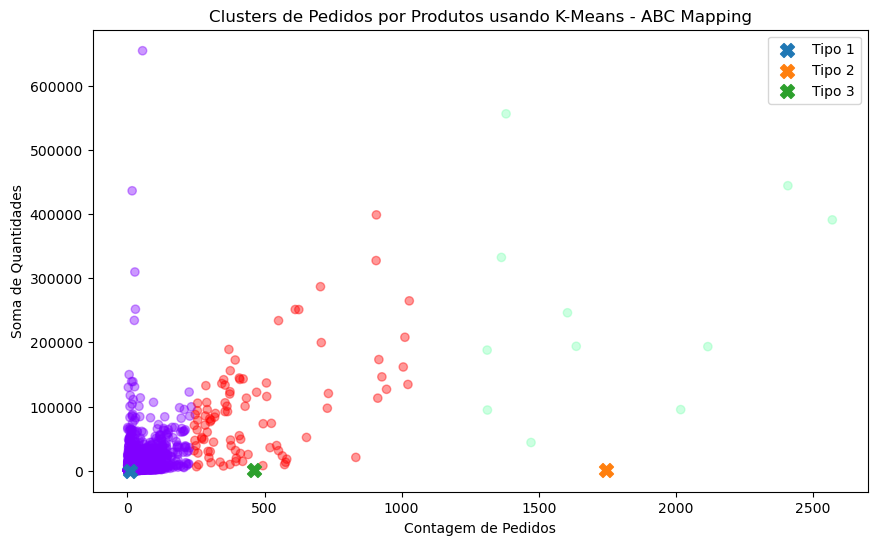

In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
%matplotlib inline

"""
Esta etapa é responsável pela agrupamento e classificação de produtos em três faixas de demanda,
para estratégia de picking em ondas, a classificação ABC é definitiva para o modelo de otimização do slotting.
"""

# Selecionando as variáveis para o K-Means
X = resume[['ContagemPedidos']]

# Criando o modelo K-Means com 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# Adicionando as labels de cluster aos dados
resume['Cluster'] = kmeans.labels_

# Plotando os clusters e centroids
plt.figure(figsize=(10, 6))

# Plot dos dados com alpha 0.4
plt.scatter(resume['ContagemPedidos'], resume['SomaQuantidades'], c=resume['Cluster'], cmap='rainbow', alpha=0.4)

# Plot dos centroids com alpha 1.0
for i, centroid in enumerate(kmeans.cluster_centers_):
    plt.scatter(centroid, centroid,  marker='X', s=100,alpha=1.0, label=f'Tipo {i+1}')

plt.xlabel('Contagem de Pedidos')
plt.ylabel('Soma de Quantidades')
plt.title('Clusters de Pedidos por Produtos usando K-Means - ABC Mapping')

plt.legend()

plt.show()


In [4]:
"""
Foi aplicado um limitador de 200 produtos para o treinamento do algoritmo em razão do custo computacional
Para rodar para toda a base, comente a linha: resume = resume.head(200)
"""
resume = resume.head(200)

produtos = resume.index.to_list()

ruas = range(1, 21)

enderecos = range(1, 21)

slots = range(1,3)


"""
A disposição do slotting será otimizada pela relevância apontada pela classificação ABC obtida no Kmeans
"""
demanda = resume['Cluster'].to_dict()

In [10]:
%pip install pulp
import pulp

# Instância do problema
prob = pulp.LpProblem("Problema de Slotting", pulp.LpMinimize)

# Variáveis de decisão
x = {}
for p in produtos:
    for r in ruas:
        for a1 in enderecos:
            for a2 in slots:
                x[p, r, a1, a2] = pulp.LpVariable(f"x_{p}_{r}_{a1}_{a2}", 0, 1, pulp.LpBinary)

# Função objetivo - minimizar a distância total percorrida
distancia_total = pulp.lpSum(
    x[p, r, a1, a2] * demanda[p] * (abs(r - a1) + abs(a1 - a2))
    for p in produtos
    for r in ruas
    for a1 in enderecos
    for a2 in slots
)

prob += distancia_total

# Restrições - cada produto alocado apenas uma vez
for p in produtos:
    prob += pulp.lpSum(x[p, r, a1, a2] for r in ruas for a1 in enderecos for a2 in slots) <= 1

# Resolvendo o problema
prob.solve()

# Imprimindo plano de Slotting
for p in produtos:
    for r in ruas:
        for a1 in enderecos:
            for a2 in slots:
                if x[p, r, a1, a2].value() == 1:
                    print(f"Produto {p} => Rua {r}, Endereço: {a1}, Slot:{a2}")


Note: you may need to restart the kernel to use updated packages.
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/anaconda3/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rq/rz1rlf4j7sb_y5hrjhb1hb0m0000gn/T/971c4f96ae3542ec938cdcb8d51f6455-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rq/rz1rlf4j7sb_y5hrjhb1hb0m0000gn/T/971c4f96ae3542ec938cdcb8d51f6455-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 205 COLUMNS
At line 480207 RHS
At line 480408 BOUNDS
At line 640410 ENDATA
Problem MODEL has 200 rows, 160001 columns and 160000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.08 seconds
Cgl0008I 200 inequality constraints converted to equality constraints
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer 